## Initial Steps

### Load Data

In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(transform_output="pandas")

In [2]:
df = pd.read_csv('../data/model_dataset/whole_dataset2001-2019.tsv', sep='\t', encoding='utf8')
y = df['Proj_PTS/GP']
X = df.drop(columns=['Proj_PTS/GP'])

In [149]:
X.shape

(914, 57)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

In [145]:
X_train.describe()

GP           G           A         PTS         PGP          PG   
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000  \
mean    62.871409   23.500684   31.023256   54.523940    8.667579    2.938440   
std      9.281438   11.341568   15.839893   25.078134    6.485201    3.524519   
min      2.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     60.000000   16.000000   20.000000   37.000000    4.000000    0.000000   
50%     66.000000   23.000000   29.000000   53.000000    7.000000    2.000000   
75%     68.000000   31.000000   40.000000   69.000000   13.000000    4.000000   
max     73.000000   66.000000  102.000000  168.000000   24.000000   21.000000   

               PA        PPTS         +/-         PIM  ...   PATT  PSOWG   
count  731.000000  731.000000  731.000000  731.000000  ...  731.0  731.0  \
mean     3.885089    6.823529    5.517100   58.203830  ...    0.0    0.0   
std      4.547218    7.498332   16.939964   49.395949  ...    0.0    0.0   
min      0.000000    0.000000  -72.000000    0.000000  ...    0.0    0.0   
25%      0.000000    1.000000   -4.000000   26.000000  ...    0.0    0.0   
50%      2.000000    5.000000    4.000000   48.000000  ...    0.0    0.0   
75%      6.000000   10.000000   16.000000   76.000000  ...    0.0    0.0   
max     28.000000   49.000000   78.000000  432.000000  ...    0.0    0.0   

        PSO%        PFOA        PFOW        PFO%      PPTS/G      PPIM/G   
count  731.0  731.000000  731.000000  731.000000  731.000000  731.000000  \
mean     0.0   24.123119   11.984952   13.241176    0.618878    0.823953   
std      0.0   68.977313   36.158419   24.231633    0.515222    0.926613   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000000    0.000000    0.000000    0.200000    0.000000   
50%      0.0    0.000000    0.000000    0.000000    0.560000    0.600000   
75%      0.0    2.000000    1.000000   25.000000    0.935000    1.200000   
max      0.0  651.000000  342.000000  100.000000    2.450000    8.750000   

           Height      Weight  
count  731.000000  731.000000  
mean   181.525308  191.922025  
std      5.379347   16.608982  
min    162.500000  140.000000  
25%    177.500000  180.000000  
50%    182.500000  190.000000  
75%    185.000000  204.000000  
max    200.000000  265.000000  

[8 rows x 54 columns]

In [146]:
y_train.value_counts()

Proj_PTS/GP
Not_In_NHL_AHL    174
Other              97
AHL [0.2, 0.4)     75
AHL [0.4, 0.6)     64
NHL [0.2, 0.4)     57
AHL [0.0, 0.2)     48
NHL [0.4, 0.6)     46
AHL [0.6, 0.8)     44
NHL [0.6, 0.8)     35
NHL [0.0, 0.2)     31
AHL [0.8, 1.0)     26
NHL [0.8, 1.0)     15
NHL [1.0, ...]     10
AHL [1.0, ...]      9
Name: count, dtype: int64

## Pipeline Components

### Formatting

Transformer to remove the features mentioned in the analysis

In [4]:
class RemoveFeatures(TransformerMixin, BaseEstimator):
    def __init__(self, features_to_remove):
        self.features_to_remove = features_to_remove
        
    def fit(self, X, y=None):
        return self
    
    # Remove the features that won't be used
    def transform(self, X):
        return X.drop(columns=self.features_to_remove)

### Feature Scaling

Transformer to scale the features (automatic: without manually checking the distributions)

In [5]:
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, RobustScaler

In [6]:
class AutomaticFeatureScaling(TransformerMixin, BaseEstimator):
    def __init__(self, skew_gap=1, kurtosis_gap=1):
        self.skew_gap = skew_gap
        self.kurtosis_gap = kurtosis_gap
        self.scalers = {}

    def fit(self, X, y=None):
        for col in X.columns:
            col_skew = skew(X[col])
            col_kurtosis = kurtosis(X[col], fisher=True)
            if (abs(col_skew) <= self.skew_gap) and (abs(col_kurtosis) <= self.kurtosis_gap):
                self.scalers[col] = StandardScaler()
            else:
                self.scalers[col] = RobustScaler()
            self.scalers[col].fit(X[[col]])
        return self
    
    def transform(self, X):
        X_scaled = X.copy(deep=True)
        for col, scaler in self.scalers.items():
            X_scaled[col] = scaler.transform(X[[col]])
        return X_scaled

### Missing Values and Outliers

Custom Negative Binomial Regression Estimator

In [7]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [8]:
class NegativeBinomialEstimator(TransformerMixin, BaseEstimator):
    def __init__(self, param=[]):
        self.NB2 = None
        self.param=param

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        y_series = pd.Series(y)
        y_series.name = "PIM"
        df_train = pd.concat([X_df, y_series], axis=1)

        #Using the statsmodels GLM class, train the Poisson regression model on the training data set
        poisson_training_results = sm.GLM(y_series, X_df, family=sm.families.Poisson()).fit()

        #Add the λ vector as a new column called 'LAMBDA' to the Data Frame of the training data set
        df_train['LAMBDA'] = poisson_training_results.mu

        #add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
        df_train['AUX_OLS_DEP'] = df_train.apply(
            lambda x: ((x['PIM'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'],
            axis=1
        )

        #use patsy to form the model specification for the OLSR
        ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""

        #Configure and fit the OLSR model
        aux_olsr_results = smf.ols(ols_expr, df_train).fit()

        #train the NB2 model on the training data set
        nb2_fitted_model = sm.GLM(y_series, X_df,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
        self.NB2 = nb2_fitted_model
        return self
    
    def predict(self, X):
        nb2_predictions = self.NB2.get_prediction(X)
        predictions_summary_frame = nb2_predictions.summary_frame()
        predictions = predictions_summary_frame['mean']
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        numerator = ((y - predictions)**2).sum()
        denominator = ((y - y.mean())**2).sum()     
        rsquared = 1 - numerator / denominator
        return rsquared

Transformer to impute the missing values

In [9]:
class MissingValueImputation(TransformerMixin, BaseEstimator):
    def __init__(self, pm_model, ppm_model, pim_model):
        self.pm_model = pm_model
        self.ppm_model = ppm_model
        self.pim_model = pim_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Impute +/- statistic
        X_missing_pm = X.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'QMJHL') & (X['G'] != 0)].copy()
        X_known_pm = X.loc[~((X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'QMJHL') & (X['G'] != 0))].copy()
        X_missing_pm.loc[:, '+/-'] = self.pm_model.predict(X_missing_pm)
        X = pd.concat([X_known_pm, X_missing_pm])

        # Impute P+/- statistic
        X_missing_ppm = X.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'QMJHL') & (X['G'] != 0)].copy()
        X_known_ppm = X.loc[~((X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'QMJHL') & (X['G'] != 0))].copy()
        X_missing_ppm.loc[:, 'P+/-'] = self.ppm_model.predict(X_missing_ppm)
        X = pd.concat([X_known_ppm, X_missing_ppm])

        # Impute PIM and PIM/G statistic
        X_missing_pim = X.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'WHL') & (X['G'] != 0)].copy()
        X_known_pim = X.loc[~((X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'WHL') & (X['G'] != 0))].copy()
        X_missing_pim.loc[:, 'PIM'] = self.pim_model.predict(X_missing_pim)
        X_missing_pim.loc[:, 'PIM/G'] = X_missing_pim['PIM'] / X_missing_pim['G']

        # Remove the Year feature as it will no longer be used
        X_known_pim = X_known_pim.drop(columns=['Year'])
        X_missing_pim = X_missing_pim.drop(columns=['Year'])

        return pd.concat([X_known_pim, X_missing_pim])

### Correlation

Note: I checked every group of correlated features and selected the features that needed to be dropped by keeping those that I believed are the most important (domain knowledge). Removing e.g. the subsequent correlated features automatically is not always appropriate

In [10]:
class RemoveHighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, type='Pearson'):
        self.type = type
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if (self.type in ['Pearson', 'Kendall']):
            return X.drop(columns=['SOGP'])
        else:
            return X.drop(columns=['PA', 'SOGP', 'SO/G'])

### Feature Selection

In [11]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

In [12]:
class MutualInfoFS(BaseEstimator, TransformerMixin):
    def __init__(self, n=None):
        self.n = n # The best n features will be kept
        self.indices = None

    def fit(self, X, y):
        mutual_info = mutual_info_regression(X, y)
        indices = np.argsort(mutual_info)[-self.n:]
        self.indices = indices
        return self
    
    def transform(self, X):
        return X.iloc[:, self.indices]


### Custom Weighted Cohen's Kappa

In [13]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer

In [14]:
classes_ordered = ['NHL [1.0, ...]', 'NHL [0.8, 1.0)', 'NHL [0.6, 0.8)', 'NHL [0.4, 0.6)', 'NHL [0.2, 0.4)', 'NHL [0.0, 0.2)',
                   'AHL [1.0, ...]', 'AHL [0.8, 1.0)', 'AHL [0.6, 0.8)', 'AHL [0.4, 0.6)', 'AHL [0.2, 0.4)', 'AHL [0.0, 0.2)',
                   'Not_In_NHL_AHL', 'Other']
labels = [i for i in range(13)] # 'Other' is not consider

In [15]:
value_index_map = {value: idx for idx, value in enumerate(classes_ordered)}
index_value_map = {str(idx): value for idx, value in enumerate(classes_ordered)}

In [68]:
def custom_cohen_kappa(y_true, y_pred):
    # If the input is encoded, decode it
    if isinstance(y_true, np.ndarray):
        y_true = np.array([index_value_map[str(index)] for index in y_true])
        y_pred = np.array([index_value_map[str(index)] for index in y_pred])
    
    # Remove the Other category from the metric computation
    true_others = np.where(y_true == 'Other')[0]
    pred_others = np.where(y_pred == 'Other')[0]
    other_mask = np.ones(y_true.shape[0], dtype=bool)
    other_indices = np.unique(np.concatenate((true_others, pred_others)))
    other_mask[other_indices] = False

    y_true_not_other = y_true[other_mask]
    y_pred_not_other = y_pred[other_mask]

    y_true_ordinal = np.array([value_index_map[value] for value in y_true_not_other])
    y_pred_ordinal = np.array([value_index_map[value] for value in y_pred_not_other])

    return cohen_kappa_score(y_true_ordinal, y_pred_ordinal, labels=labels, weights='quadratic')
        

In [69]:
custom_cohen_kappa_scorer = make_scorer(custom_cohen_kappa, greater_is_better=True)

### Rebate

ReliefF

In [17]:
from skrebate import ReliefF

In [18]:
class ReliefFDF(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_to_select=None, n_neighbors=None):
        self.n_features_to_select = n_features_to_select
        self.n_neighbors = n_neighbors
        self.relieff = None

    def fit(self, X, y):
        self.relieff = ReliefF(n_features_to_select=self.n_features_to_select, n_neighbors=self.n_neighbors)
        if not isinstance(X, np.ndarray):
            X = X.values
        if not (isinstance(y, np.ndarray)):
            y = np.array(y.map(value_index_map))
        return self.relieff.fit(X, y)
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.values
        return self.relieff.transform(X)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return pd.DataFrame(self.transform(X))
        

SURF

In [19]:
from skrebate import SURF

In [20]:
class SURFDF(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_to_select=None):
        self.n_features_to_select = n_features_to_select
        self.surf = None

    def fit(self, X, y):
        self.surf = SURF(n_features_to_select=self.n_features_to_select)
        if not isinstance(X, np.ndarray):
            X = X.values
        if not (isinstance(y, np.ndarray)):
            y = np.array(y.map(value_index_map))
        return self.surf.fit(X, y)
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.values
        return self.surf.transform(X)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return pd.DataFrame(self.transform(X))

SURF*

In [21]:
from skrebate import SURFstar

In [22]:
class SURFstarDF(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_to_select=None):
        self.n_features_to_select = n_features_to_select
        self.surfstar = None

    def fit(self, X, y):
        self.surfstar = SURFstar(n_features_to_select=self.n_features_to_select)
        if not isinstance(X, np.ndarray):
            X = X.values
        if not (isinstance(y, np.ndarray)):
            y = np.array(y.map(value_index_map))
        return self.surfstar.fit(X, y)
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.values
        return self.surfstar.transform(X)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return pd.DataFrame(self.transform(X))

MultiSURF

In [23]:
from skrebate import MultiSURF

In [24]:
class MultiSURFDF(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_to_select=None):
        self.n_features_to_select = n_features_to_select
        self.multisurf = None

    def fit(self, X, y):
        self.multisurf = MultiSURF(n_features_to_select=self.n_features_to_select)
        if not isinstance(X, np.ndarray):
            X = X.values
        if not (isinstance(y, np.ndarray)):
            y = np.array(y.map(value_index_map))
        return self.multisurf.fit(X, y)
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.values
        return self.multisurf.transform(X)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return pd.DataFrame(self.transform(X))

MultiSURF*

In [25]:
from skrebate import MultiSURFstar

In [26]:
class MultiSURFstarDF(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_to_select=None):
        self.n_features_to_select = n_features_to_select
        self.multisurfstar = None

    def fit(self, X, y):
        self.multisurfstar = MultiSURFstar(n_features_to_select=self.n_features_to_select)
        if not isinstance(X, np.ndarray):
            X = X.values
        if not (isinstance(y, np.ndarray)):
            y = np.array(y.map(value_index_map))
        return self.multisurfstar.fit(X, y)
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.values
        return self.multisurfstar.transform(X)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return pd.DataFrame(self.transform(X))

### Neural Network

In [18]:
from sklearn.preprocessing import LabelBinarizer
from keras import layers, models, optimizers, regularizers

In [19]:
class NeuralNetworkEstimator(TransformerMixin, BaseEstimator):
    def __init__(self, widths=None, learning_rate=None, beta1=None, beta2=None,
                 weight_initializer=None, batch_size=None, epochs=None, dropout=False,
                 l2_reg = False, l1_reg = False): # Depth := len(widths)
        # NN Structure parameters
        self.widths = widths
        self.weight_initializer = weight_initializer
        self.dropout = dropout
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg

        # Adam optimizer parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2

        # Fit parameters
        self.batch_size = batch_size
        self.epochs = epochs

        # Objects
        self.sequential_model = None
        self.label_binarizer = LabelBinarizer()


    def fit(self, X, y):
        # Encode the target and compute the class_weights (similar to sklearn)
        nb_classes = y.value_counts().shape[0]
        nb_samples = y.shape[0]
        y_encoded = self.label_binarizer.fit_transform(y)
        class_frequencies = np.sum(y_encoded, axis=0)
        class_weights = {i: nb_samples/(nb_classes*freq) for i, freq in enumerate(class_frequencies)}

        # Set up the layers
        nn_layers = [layers.InputLayer(input_shape=(X.shape[1],))]
        for width in self.widths:
            if (self.dropout):
                nn_layers.append(layers.Dropout(0.5))

            if (self.l2_reg):
                nn_layers.append(layers.Dense(width, activation='relu',
                                          kernel_initializer=self.weight_initializer,
                                          kernel_regularizer=regularizers.l2(0.01)))
            elif (self.l1_reg):
                nn_layers.append(layers.Dense(width, activation='relu',
                                          kernel_initializer=self.weight_initializer,
                                          kernel_regularizer=regularizers.l1(0.01)))
            else:
                nn_layers.append(layers.Dense(width, activation='relu',
                                          kernel_initializer=self.weight_initializer))

        if (self.dropout):
            nn_layers.append(layers.Dropout(0.5))
        nn_layers.append(layers.Dense(14, activation='softmax'))
        self.sequential_model = models.Sequential(nn_layers)

        self.sequential_model.compile(
            optimizer=optimizers.Adam(learning_rate=self.learning_rate, 
                                      beta_1=self.beta1,
                                      beta_2=self.beta2),
            loss = 'categorical_crossentropy'
        )

        self.sequential_model.fit(X, y_encoded, epochs=self.epochs, batch_size=self.batch_size, 
                                  class_weight=class_weights, verbose=0)
        return self
    

    def predict(self, X):
        encoded_predictions = self.sequential_model.predict(X)
        max_indices = np.argmax(encoded_predictions, axis=1)
        classes = self.label_binarizer.classes_
        predicted_classes = classes[max_indices]
        return predicted_classes

## Data Analysis

### Proportion of Missing Values

DS stat missing:

In [4]:
df_qmjhl_ds_recorded = df.loc[(df['Year'].str[:4].astype(int) >= 2010) & (df['League'] == 'QMJHL')]
df_ohl_ds_recorded = df.loc[(df['Year'].str[:4].astype(int) >= 2015) & (df['League'] == 'OHL')]
df_qmjhl_ds_recorded.shape[0] + df_ohl_ds_recorded.shape[0]

164

Faceoffs stats missing (FOA, FOW, FO%) and SOG stat missing:

In [5]:
df_qmjhl_faceoffs_recorded = df.loc[df['League'] == 'QMJHL']
df_ohl_faceoofs_recorded = df.loc[(df['Year'].str[:4].astype(int) > 2014) & (df['League'] == 'OHL')]
df_whl_faceoofs_recorded = df.loc[(df['Year'].str[:4].astype(int) > 2016) & (df['League'] == 'WHL')]
df_qmjhl_faceoffs_recorded.shape[0] + df_ohl_faceoofs_recorded.shape[0] + df_whl_faceoofs_recorded.shape[0]

316

+/- stat missing:

In [7]:
df_qmjhl_plusminus_not_recorded = df.loc[(df['Year'].str[:4].astype(int) <= 2002) & (df['League'] == 'QMJHL')]
df_qmjhl_plusminus_not_recorded.shape[0]

48

PIM, PIM/G stats missing:

In [8]:
df_whl_pim_not_recorded = df.loc[(df['Year'].str[:4].astype(int) <= 2002) & (df['League'] == 'WHL')]
df_whl_pim_not_recorded.shape[0]

71

Missing Values Pipeline Component

In [12]:
X = df
remove_feature_transformer = RemoveFeatures(['DS', 'PDS', 'FOA', 'FOW', 'FO%', 'PFOA', 'PFOW', 'PFO%', 'SOG', 'PSOG'])
remove_feature_transformer.fit(X)
X_obtained = remove_feature_transformer.transform(X)
print(X_obtained.columns)
print(X_obtained.shape)


Index(['League', 'GP', 'G', 'A', 'PTS', 'PGP', 'PG', 'PA', 'PPTS',
       'Proj_PTS/GP', 'Position', '+/-', 'PIM', 'PPG', 'PPA', 'SHG', 'SHA',
       'GWG', 'OTG', 'First', 'Insurance', 'SOGP', 'SO/G', 'ATT', 'SOWG',
       'SO%', 'PTS/G', 'PIM/G', 'Year', 'P+/-', 'PPIM', 'PPPG', 'PPPA', 'PSHG',
       'PSHA', 'PGWG', 'POTG', 'PFirst', 'PInsurance', 'PSOGP', 'PSO/G',
       'PATT', 'PSOWG', 'PSO%', 'PPTS/G', 'PPIM/G', 'Height', 'Weight'],
      dtype='object')
(914, 48)


In [19]:
X = df
remove_feature_transformer = RemoveFeatures(['P+/-', 'PIM', 'PIM/G', 'Proj_PTS/GP'])
remove_feature_transformer.fit(X)
X_obtained = remove_feature_transformer.transform(X)
print(X_obtained.columns)
print(X_obtained.shape)

Index(['League', 'GP', 'G', 'A', 'PTS', 'PGP', 'PG', 'PA', 'PPTS', 'Position',
       '+/-', 'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'OTG', 'First', 'Insurance',
       'SOGP', 'SO/G', 'ATT', 'SOWG', 'SO%', 'PTS/G', 'Year', 'PPIM', 'PPPG',
       'PPPA', 'PSHG', 'PSHA', 'PGWG', 'POTG', 'PFirst', 'PInsurance', 'PSOGP',
       'PSO/G', 'PATT', 'PSOWG', 'PSO%', 'PPTS/G', 'PPIM/G', 'Height',
       'Weight'],
      dtype='object')
(914, 44)


### Classification Problem Investigation

Checking if we have class imbalance

In [104]:
y_train.value_counts()

Proj_PTS/GP
Not_In_NHL_AHL    174
Other              97
AHL [0.2, 0.4)     75
AHL [0.4, 0.6)     64
NHL [0.2, 0.4)     57
AHL [0.0, 0.2)     48
NHL [0.4, 0.6)     46
AHL [0.6, 0.8)     44
NHL [0.6, 0.8)     35
NHL [0.0, 0.2)     31
AHL [0.8, 1.0)     26
NHL [0.8, 1.0)     15
NHL [1.0, ...]     10
AHL [1.0, ...]      9
Name: count, dtype: int64

So there clearly is class imbalance. We might want to consider the effect of using sampling techniques like SMOTE to tackle this issue

## Imputation Models

### Training dataset prior to missing value imputation

First Step of the Pipeline

In [154]:
features_to_remove = ['DS', 'PDS', 'FOA', 'FOW', 'FO%', 'PFOA', 'PFOW', 'PFO%', 'SOG', 'PSOG', 'PSOWG', 'PSOGP', 'PSO/G', 'PSO%', 'PATT']
features_to_encode = ['League', 'Position']
features_to_impute = ['+/-', 'P+/-', 'PIM', 'PIM/G']

In [155]:
X_train_before_mvi = RemoveFeatures(features_to_remove).fit_transform(X_train)

In [156]:
numerical_features = [c for c in X_train_before_mvi.columns if c not in features_to_encode + features_to_impute + ['Year']]

Then we do missing value imputation

### KNN model for +/- Imputation

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

Retrieve the records with known +/- values

In [157]:
known_plusmins_values = X_train_before_mvi.loc[~((X_train_before_mvi['Year'].str[:4].astype(int) <= 2002) & (X_train_before_mvi['League'] == 'QMJHL') & (X_train_before_mvi['G'] != 0))]
y_known_plusminus_values = known_plusmins_values['+/-']
X_known_plusminus_values = known_plusmins_values.drop(columns=['+/-'])

Split between training and testing sets

In [158]:
X_kpm_train, X_kpm_test, y_kpm_train, y_kpm_test = train_test_split(X_known_plusminus_values, y_known_plusminus_values, test_size=0.2, random_state=22)

Build the Pipeline

In [159]:
data_preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_to_encode),
        ('numerical', AutomaticFeatureScaling(), numerical_features),
    ]
)

In [160]:
imputation_pm_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('dimensionality_reduction', PCA()),
    ('model', KNeighborsRegressor())
])
imputation_pm_model

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['League', 'Position']),
                                                 ('numerical',
                                                  AutomaticFeatureScaling(),
                                                  ['GP', 'G', 'A', 'PTS', 'PGP',
                                                   'PG', 'PA', 'PPTS', 'PPG',
                                                   'PPA', 'SHG', 'SHA', 'GWG',
                                                   'OTG', 'First', 'Insurance',
                                                   'SOGP', 'SO/G', 'ATT',
                                                   'SOWG', 'SO%', 'PTS/G',
                                                   'PPIM', 'PPPG', 'PPPA',
                                                   'PSHG', 'PSHA', 'PGWG',
                                                   'POTG', 'PFirst', ...])])),
                ('dimensionality_reduction', PCA()),
                ('model', KNeighborsRegressor())])

Hyper-parameter tuning and model training

In [161]:
param_grid_pm = dict(
    dimensionality_reduction__n_components = [2, 5, 10, 15, 20],
    model__n_neighbors = [1, 5, 10, 15, 20, 50],
)

In [162]:
best_model_pm = GridSearchCV(imputation_pm_model, param_grid_pm)
best_model_pm.fit(X_kpm_train, y_kpm_train)
best_model_pm.best_params_

{'dimensionality_reduction__n_components': 10, 'model__n_neighbors': 20}

In [164]:
best_model_pm.best_score_

0.37227521898375127

In [163]:
best_model_pm.score(X_kpm_test, y_kpm_test)

0.3146665448093695

Save the model

In [107]:
import joblib
from pathlib import Path

In [108]:
Path(f"../models/imputation_models").mkdir(parents=True, exist_ok=True)
filename_pm_imputation_model = Path("../models/imputation_models/pm_imputation_model.pkl")
joblib.dump(best_model_pm, filename_pm_imputation_model, compress=1)

['..\\models\\imputation_models\\pm_imputation_model.pkl']

### KNN model for P+/- Imputation

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

Split the data between known values and missing values

In [166]:
known_ppm_values = X_train_before_mvi.loc[~((X_train_before_mvi['Year'].str[:4].astype(int) <= 2002) & (X_train_before_mvi['League'] == 'QMJHL') & (X_train_before_mvi['G'] != 0))]
y_known_ppm_values = known_ppm_values['P+/-']
X_known_ppm_values = known_ppm_values.drop(columns=['P+/-'])

Split between training and testing sets

In [167]:
X_kppm_train, X_kppm_test, y_kppm_train, y_kppm_test = train_test_split(X_known_ppm_values, y_known_ppm_values, test_size=0.2, random_state=22)

Build the Pipeline

In [168]:
data_preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_to_encode),
        ('numerical', AutomaticFeatureScaling(), numerical_features)
    ]
)

In [169]:
imputation_ppm_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('dimensionality_reduction', PCA()),
    ('model', KNeighborsRegressor())
])
imputation_ppm_model

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['League', 'Position']),
                                                 ('numerical',
                                                  AutomaticFeatureScaling(),
                                                  ['GP', 'G', 'A', 'PTS', 'PGP',
                                                   'PG', 'PA', 'PPTS', 'PPG',
                                                   'PPA', 'SHG', 'SHA', 'GWG',
                                                   'OTG', 'First', 'Insurance',
                                                   'SOGP', 'SO/G', 'ATT',
                                                   'SOWG', 'SO%', 'PTS/G',
                                                   'PPIM', 'PPPG', 'PPPA',
                                                   'PSHG', 'PSHA', 'PGWG',
                                                   'POTG', 'PFirst', ...])])),
                ('dimensionality_reduction', PCA()),
                ('model', KNeighborsRegressor())])

Hyper-parameter tuning and model training

In [170]:
param_grid_ppm = dict(
    dimensionality_reduction__n_components = [2, 5, 10, 15, 20],
    model__n_neighbors = [1, 5, 10, 15, 20, 50],
)

In [171]:
best_model_ppm = GridSearchCV(imputation_ppm_model, param_grid_ppm)
best_model_ppm.fit(X_kppm_train, y_kppm_train)
best_model_ppm.best_params_

{'dimensionality_reduction__n_components': 10, 'model__n_neighbors': 20}

In [173]:
best_model_ppm.best_score_

0.3132006976901803

In [172]:
best_model_ppm.score(X_kppm_test, y_kppm_test)

0.28124629931044365

In [313]:
import joblib
from pathlib import Path

In [314]:
Path(f"../models/imputation_models").mkdir(parents=True, exist_ok=True)
filename_ppm_imputation_model = Path("../models/imputation_models/ppm_imputation_model.pkl")
joblib.dump(best_model_ppm, filename_ppm_imputation_model, compress=1)

['..\\models\\imputation_models\\ppm_imputation_model.pkl']

### Negative Binomial Regression model for PIM Imputation

In [571]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Split the data between known and missing values

In [572]:
other_features = ['Year', '+/-', 'P+/-', 'PIM/G']

In [573]:
known_pim_values = X_train_before_mvi.loc[~((X_train_before_mvi['Year'].str[:4].astype(int) <= 2002) & (X_train_before_mvi['League'] == 'WHL') & (X_train_before_mvi['G'] != 0))]
y_known_pim_values = known_pim_values['PIM']
X_known_pim_values = known_pim_values.drop(columns=['PIM'])

Split data between training and testing sets

In [574]:
X_kpim_train, X_kpim_test, y_kpim_train, y_kpim_test = train_test_split(X_known_pim_values, y_known_pim_values, test_size=0.2, random_state=22)

Negative Binomial (NB2) Estimator (reference: https://timeseriesreasoning.com/contents/negative-binomial-regression-model/)

In [575]:
data_preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_to_encode),
        ('remove_imputation_features', RemoveFeatures(other_features), other_features),
    ],
    remainder='passthrough',
)

In [576]:
imputation_pim_model_nb2_fs = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('feature_selection', MutualInfoFS()),
    ('model', NegativeBinomialEstimator())
]
)

In [577]:
param_grid_pim = dict(
    feature_selection__n = [5, 10, 15, 20, 25, 30, 35, 40],
)

In [578]:
grid_search_nb2 = GridSearchCV(imputation_pim_model_nb2_fs, param_grid_pim)
grid_search_nb2.fit(X_kpim_train, y_kpim_train)

GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['League',
                                                                          'Position']),
                                                                        ('remove_imputation_features',
                                                                         RemoveFeatures(features_to_remove=['Year',
                                                                                                            '+/-',
                                                                                                            'P+/-',
                                                                                                            'PIM/G']),
                                                                         ['Year',
                                                                          '+/-',
                                                                          'P+/-',
                                                                          'PIM/G'])])),
                                       ('feature_selection', MutualInfoFS()),
                                       ('model', NegativeBinomialEstimator())]),
             param_grid={'feature_selection__n': [5, 10, 15, 20, 25, 30, 35,
                                                  40]})

In [579]:
grid_search_nb2.best_params_

{'feature_selection__n': 30}

In [580]:
grid_search_nb2.best_score_

0.15625344118716883

In [581]:
grid_search_nb2.score(X_kpim_test, y_kpim_test)

0.18354003896151705

In [582]:
import joblib
from pathlib import Path

In [583]:
Path(f"../models/imputation_models").mkdir(parents=True, exist_ok=True)
filename_pim_imputation_model = Path("../models/imputation_models/pim_imputation_model.pkl")
joblib.dump(grid_search_nb2, filename_pim_imputation_model, compress=1)

['..\\models\\imputation_models\\pim_imputation_model.pkl']

### Imputation Test

In [141]:
missing_value_imputer = MissingValueImputation(best_model_pm, best_model_ppm, imputation_pim_model_with_scaling)
X_numeric = X_train.select_dtypes(include=[np.number])

In [142]:
X_transformed = missing_value_imputer.fit_transform(X_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [144]:
import seaborn as sns

In [152]:
X_missing_pm = X_train.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X_train['League'] == 'QMJHL')].copy()
X_missing_pm['+/-'].value_counts()

+/-
0    37
Name: count, dtype: int64

<Axes: xlabel='+/-', ylabel='Count'>

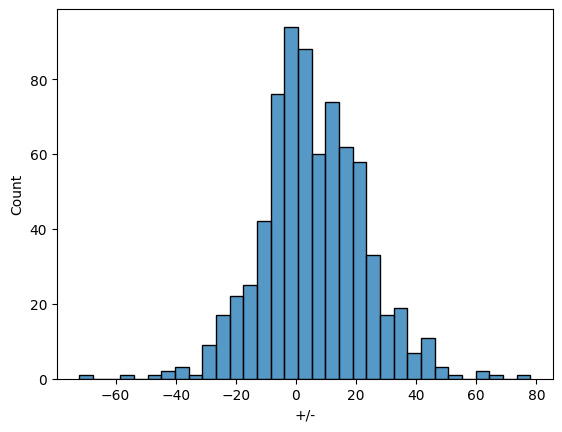

In [151]:
sns.histplot(X_transformed['+/-'])

In [154]:
X_missing_ppm = X_train.loc[(X_train['Year'].str[:4].astype(int) <= 2002) & (X_train['League'] == 'QMJHL')].copy()
X_missing_ppm['P+/-'].value_counts()

P+/-
0    37
Name: count, dtype: int64

<Axes: xlabel='P+/-', ylabel='Count'>

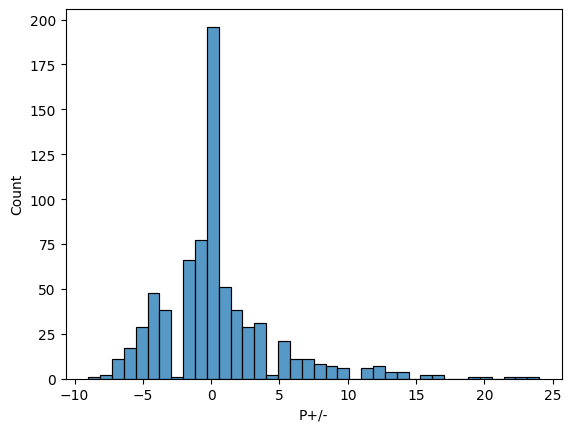

In [155]:
sns.histplot(X_transformed['P+/-'])

In [156]:
X_missing_pim = X.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'WHL')].copy()
X_missing_pim['PIM'].value_counts()

PIM
0    71
Name: count, dtype: int64

<Axes: xlabel='PIM', ylabel='Count'>

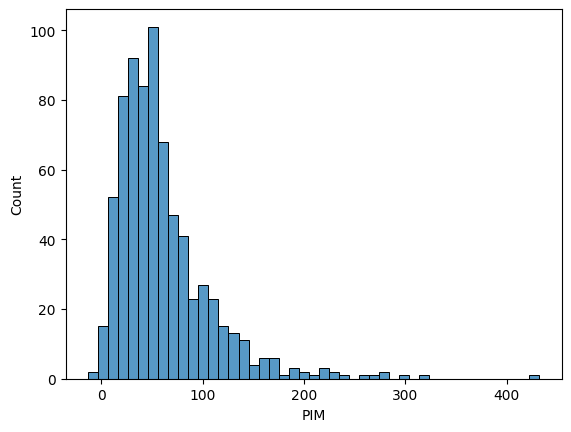

In [157]:
sns.histplot(X_transformed['PIM'])

In [158]:
X_missing_pimg = X.loc[(X['Year'].str[:4].astype(int) <= 2002) & (X['League'] == 'WHL')].copy()
X_missing_pimg['PIM/G'].value_counts()

PIM/G
0.0    71
Name: count, dtype: int64

<Axes: xlabel='PIM/G', ylabel='Density'>

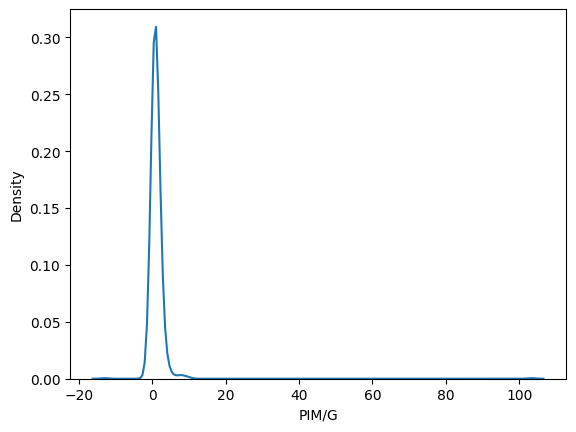

In [161]:
sns.kdeplot(X_transformed['PIM/G'])

## Correlation Analysis

### Data Preprocessing

Build the Pipeline until correlation

In [373]:
from sklearn.pipeline import Pipeline
import joblib
import seaborn as sns

In [374]:
features_to_remove_gen = ['DS', 'PDS', 'FOA', 'FOW', 'FO%', 'PFOA', 'PFOW', 'PFO%', 'SOG', "PSOGP", "PSO/G", "PATT", "PSOWG", "PSO%"]
features_to_encode = ['League', 'Position']
numerical_features = [f for f in X_train.columns if f not in (features_to_encode + features_to_remove_gen + ['Year'])]

In [375]:
pm_imputation_model = joblib.load('../models/imputation_models/pm_imputation_model.pkl')
ppm_imputation_model = joblib.load('../models/imputation_models/ppm_imputation_model.pkl')
pim_imputation_model = joblib.load('../models/imputation_models/pim_imputation_model.pkl')

In [377]:
before_correlation = Pipeline(steps=[
    ('remove_specific_features', RemoveFeatures(features_to_remove_gen)),
    ('missing_value_imputation', MissingValueImputation(pm_imputation_model, ppm_imputation_model, pim_imputation_model)),
])

In [378]:
X_train_processed = before_correlation.fit_transform(X_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [379]:
X_train_processed_numeric = X_train_processed[numerical_features]

Helper function to retrieve the correlated features

In [380]:
def find_correlated_features(correlation_matrix, threshold):
    correlated_features = []
    for i in range(len(correlation_matrix.columns)):
        x = []
        for j in range(i):
            if (abs(correlation_matrix.iloc[i, j]) >= threshold):
                if (x == []):
                    x.append(correlation_matrix.columns[i])
                colname = correlation_matrix.columns[j]
                x.append(colname)
        
        if (x != []):
            correlated_features.append(x)
    
    return correlated_features

### Pearson correlation

<Axes: >

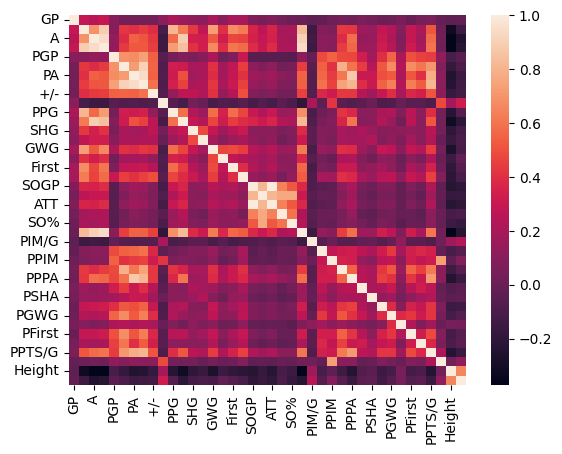

In [381]:
corr_pearson = X_train_processed_numeric.corr(method='pearson')
sns.heatmap(corr_pearson)

In [382]:
find_correlated_features(corr_pearson, 0.95)

[['ATT', 'SOGP']]

### Spearman Correlation

<Axes: >

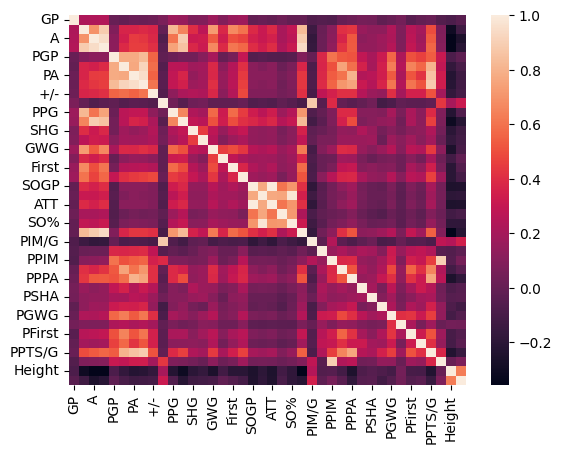

In [383]:
corr_spearman = X_train_processed_numeric.corr(method='spearman')
sns.heatmap(corr_spearman)

In [384]:
find_correlated_features(corr_spearman, 0.95)

[['PPTS', 'PA'], ['ATT', 'SOGP'], ['SO%', 'SO/G']]

### Kendall Correlation

<Axes: >

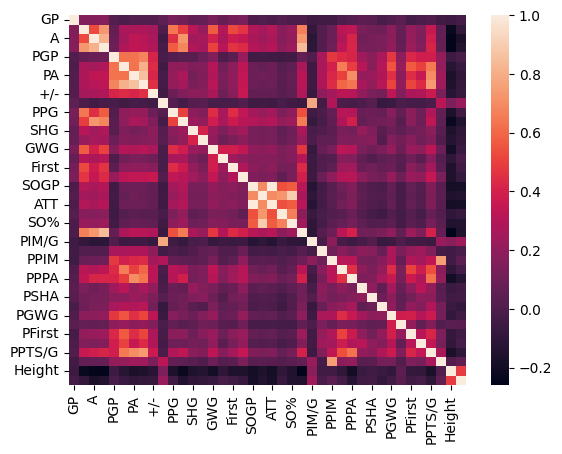

In [385]:
corr_kendall = X_train_processed_numeric.corr(method='kendall')
sns.heatmap(corr_kendall)

In [102]:
find_correlated_features(corr_kendall, 0.95)

[['ATT', 'SOGP']]

## Model Building

### Loading imputation models and key variables

Load Imputation Models

In [27]:
import joblib

In [28]:
pm_imputation_model = joblib.load('../models/imputation_models/pm_imputation_model.pkl')
ppm_imputation_model = joblib.load('../models/imputation_models/ppm_imputation_model.pkl')
pim_imputation_model = joblib.load('../models/imputation_models/pim_imputation_model.pkl')

In [ ]:
pm_imputation_model.nam

Key group of features

In [29]:
features_to_remove = ['DS', 'PDS', 'FOA', 'FOW', 'FO%', 'PFOA', 'PFOW', 'PFO%', 'SOG', 'PSOG', 'PSOWG', 'PSOGP', 'PSO/G', 'PSO%', 'PATT']
features_to_encode = ['League', 'Position']
features_to_impute = ['+/-', 'P+/-', 'PIM', 'PIM/G']
numerical_features = [f for f in X_train.columns if f not in (features_to_encode + features_to_remove + ['Year'])]

### Common Pipeline Components

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

In [25]:
numerical_preprocessing_scaling = Pipeline(steps=[
    ('remove_highly_correlated_features', RemoveHighlyCorrelatedFeatures()),
    ('feature_scaling', AutomaticFeatureScaling()),
])

In [30]:
encoding_scaling = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_to_encode),
        ('numerical', numerical_preprocessing_scaling, numerical_features)
    ],
)

In [31]:
encoding_correlated = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_to_encode),
        ('numerical', RemoveHighlyCorrelatedFeatures(), numerical_features)
    ]
)

In [32]:
data_preprocessing_scaling = Pipeline(steps=[
    ('remove_specific_features', RemoveFeatures(features_to_remove)),
    ('missing_value_imputation', MissingValueImputation(pm_imputation_model, ppm_imputation_model, pim_imputation_model)),
    ('encoding_scaling', encoding_scaling)
])

In [33]:
data_preprocessing = Pipeline(steps=[
    ('remove_specific_features', RemoveFeatures(features_to_remove)),
    ('missing_value_imputation', MissingValueImputation(pm_imputation_model, ppm_imputation_model, pim_imputation_model)),
    ('encoding_correlated', encoding_correlated)
])

In [34]:
cv_splitter = StratifiedKFold(n_splits=5)

### Softmax Regression (Baseline)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.over_sampling import SMOTE

In [40]:
param_grid_softmax = dict(
    softmax_model__penalty = ['l1', 'l2', None],
)

In [41]:
param_grid_softmax_dr = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    softmax_model__penalty = ['l1', 'l2', None],
)

In [84]:
param_grid_softmax_reliefF = dict(
    dimensionality_reduction__n_features_to_select = [5, 10, 15, 20],
    dimensionality_reduction__n_neighbors = [5, 10, 15],
    softmax_model__penalty = ['l1', 'l2', None],
)

In [99]:
param_grid_softmax_rebate = dict(
    dimensionality_reduction__n_features_to_select = [5, 10, 15, 20],
    softmax_model__penalty = ['l1', 'l2', None],
)

#### Basic

In [45]:
after_preprocessing_softmax_basic = Pipeline(steps=[
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [46]:
grid_search_softmax = GridSearchCV(
    estimator=after_preprocessing_softmax_basic,
    param_grid=param_grid_softmax,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [47]:
softmax_basic_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax)
])

In [48]:
softmax_basic_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=Pipeline(steps=[('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [49]:
clf = softmax_basic_model.named_steps['softmax']
clf.best_score_

-0.0033109231538340556

In [50]:
clf.best_params_

{'softmax_model__penalty': 'l1'}

#### Using SMOTE

In [51]:
after_preprocessing_softmax_smote = imblearn.pipeline.Pipeline(steps=[
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', random_state=22))
])

In [52]:
grid_search_softmax_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_smote,
    param_grid=param_grid_softmax,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [53]:
softmax_sampling_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_smote)
])

In [54]:
softmax_sampling_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=Pipeline(steps=[('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [55]:
clf = softmax_sampling_model.named_steps['softmax']
clf.best_score_

0.0465898635844139

In [56]:
clf.best_params_

{'softmax_model__penalty': 'l2'}

#### LDA

In [57]:
after_preprocessing_softmax_lda = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [58]:
grid_search_softmax_lda = GridSearchCV(
    estimator=after_preprocessing_softmax_lda,
    param_grid=param_grid_softmax_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [59]:
softmax_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_lda)
])

In [60]:
softmax_lda_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         LinearDiscriminantAnalysis()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [61]:
clf = softmax_lda_model.named_steps['softmax']
clf.best_score_

0.07167246958275783

In [62]:
clf.best_params_

{'dimensionality_reduction__n_components': 2, 'softmax_model__penalty': None}

#### LDA and SMOTE

In [63]:
after_preprocessing_softmax_smote_lda = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', random_state=22))
])

In [65]:
grid_search_softmax_smote_lda = GridSearchCV(
    estimator=after_preprocessing_softmax_smote_lda,
    param_grid=param_grid_softmax_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [66]:
softmax_sampling_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_smote_lda)
])

In [67]:
softmax_sampling_lda_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         LinearDiscriminantAnalysis()),
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [68]:
clf = softmax_sampling_lda_model.named_steps['softmax']
clf.best_score_

0.07645959708658952

In [69]:
clf.best_params_

{'dimensionality_reduction__n_components': 2, 'softmax_model__penalty': None}

#### PCA

In [71]:
after_preprocessing_softmax_pca = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [72]:
grid_search_softmax_pca = GridSearchCV(
    estimator=after_preprocessing_softmax_pca,
    param_grid=param_grid_softmax_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [73]:
softmax_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_pca)
])

In [74]:
softmax_pca_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         PCA()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [75]:
clf = softmax_pca_model.named_steps['softmax']
clf.best_score_

0.026790580104093565

In [76]:
clf.best_params_

{'dimensionality_reduction__n_components': 10, 'softmax_model__penalty': 'l2'}

#### PCA and SMOTE

In [77]:
after_preprocessing_softmax_smote_pca = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', random_state=22))
])

In [79]:
grid_search_softmax_smote_pca = GridSearchCV(
    estimator=after_preprocessing_softmax_smote_pca,
    param_grid=param_grid_softmax_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [80]:
softmax_sampling_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_smote_pca)
])

In [81]:
softmax_sampling_pca_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         PCA()),
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [82]:
clf = softmax_sampling_pca_model.named_steps['softmax']
clf.best_score_

0.021103315212974594

In [83]:
clf.best_params_

{'dimensionality_reduction__n_components': 10, 'softmax_model__penalty': None}

#### ReliefF

In [85]:
after_preprocessing_softmax_reliefF = Pipeline(steps=[
    ('dimensionality_reduction', ReliefFDF()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [86]:
grid_search_softmax_reliefF = GridSearchCV(
    estimator=after_preprocessing_softmax_reliefF,
    param_grid=param_grid_softmax_reliefF,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [87]:
softmax_reliefF_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_reliefF)
])

In [88]:
softmax_reliefF_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'dimensionality_reduction__n_neighbors': [5,
                                                                                    10,
                                                                                    15],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [89]:
clf = softmax_reliefF_model.named_steps['softmax']
clf.best_score_

0.04170395329791652

In [90]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 15,
 'dimensionality_reduction__n_neighbors': 15,
 'softmax_model__penalty': 'l2'}

#### ReliefF and SMOTE

In [91]:
after_preprocessing_softmax_reliefF_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', ReliefFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [92]:
grid_search_softmax_reliefF_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_reliefF_smote,
    param_grid=param_grid_softmax_reliefF,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [93]:
softmax_reliefF_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_reliefF_smote)
])

In [94]:
softmax_reliefF_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'dimensionality_reduction__n_neighbors': [5,
                                                                                    10,
                                                                                    15],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [95]:
clf = softmax_reliefF_smote_model.named_steps['softmax']
clf.best_score_

0.038348037614101216

In [96]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 10,
 'dimensionality_reduction__n_neighbors': 15,
 'softmax_model__penalty': 'l1'}

#### SURF

In [97]:
after_preprocessing_softmax_surf = Pipeline(steps=[
    ('dimensionality_reduction', SURFDF()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [101]:
grid_search_softmax_surf = GridSearchCV(
    estimator=after_preprocessing_softmax_surf,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [102]:
softmax_surf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_surf)
])

In [103]:
softmax_surf_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         SURFDF()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [104]:
clf = softmax_surf_model.named_steps['softmax']
clf.best_score_

0.08198045078756093

In [105]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 15,
 'softmax_model__penalty': 'l2'}

#### SURF and SMOTE

In [106]:
after_preprocessing_softmax_surf_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', SURFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [107]:
grid_search_softmax_surf_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_surf_smote,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [108]:
softmax_surf_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_surf_smote)
])

In [109]:
softmax_surf_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [110]:
clf = softmax_surf_smote_model.named_steps['softmax']
clf.best_score_

0.04962311835308932

In [111]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 15,
 'softmax_model__penalty': 'l1'}

#### SURF*

In [112]:
after_preprocessing_softmax_surfstar = Pipeline(steps=[
    ('dimensionality_reduction', SURFstarDF()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [113]:
grid_search_softmax_surfstar = GridSearchCV(
    estimator=after_preprocessing_softmax_surfstar,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [114]:
softmax_surfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_surfstar)
])

In [115]:
softmax_surfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         SURFstarDF()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [116]:
clf = softmax_surfstar_model.named_steps['softmax']
clf.best_score_

0.04101020364853847

In [117]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 20,
 'softmax_model__penalty': 'l1'}

#### SURF* and SMOTE

In [118]:
after_preprocessing_softmax_surfstar_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', SURFstarDF()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [119]:
grid_search_softmax_surfstar_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_surfstar_smote,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [120]:
softmax_surfstar_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_surfstar_smote)
])

In [121]:
softmax_surfstar_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [122]:
clf = softmax_surfstar_smote_model.named_steps['softmax']
clf.best_score_

0.04365522564458446

In [123]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 10,
 'softmax_model__penalty': 'l2'}

#### MultiSURF

In [124]:
after_preprocessing_softmax_multisurf = Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFDF()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [126]:
grid_search_softmax_multisurf = GridSearchCV(
    estimator=after_preprocessing_softmax_multisurf,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [127]:
softmax_multisurf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_multisurf)
])

In [128]:
softmax_multisurf_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                              estimator=Pipeline(steps=[('dimensionality_reduction',
                                                         MultiSURFDF()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [129]:
clf = softmax_multisurf_model.named_steps['softmax']
clf.best_score_

0.046851689429399726

In [130]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 20,
 'softmax_model__penalty': 'l2'}

#### MultiSURF and SMOTE

In [131]:
after_preprocessing_softmax_multisurf_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [132]:
grid_search_softmax_multisurf_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_multisurf_smote,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [133]:
softmax_multisurf_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_multisurf_smote)
])

In [134]:
softmax_multisurf_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [135]:
clf = softmax_multisurf_smote_model.named_steps['softmax']
clf.best_score_

0.045172935957681085

In [136]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 10,
 'softmax_model__penalty': 'l2'}

#### MultiSURFstar

In [137]:
after_preprocessing_softmax_multisurfstar = Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFstarDF()),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [138]:
grid_search_softmax_multisurfstar = GridSearchCV(
    estimator=after_preprocessing_softmax_multisurfstar,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [139]:
softmax_multisurfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_multisurfstar)
])

In [140]:
softmax_multisurfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         MultiSURFstarDF()),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [141]:
clf = softmax_multisurfstar_model.named_steps['softmax']
clf.best_score_

0.04248336967031245

In [142]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 10,
 'softmax_model__penalty': 'l2'}

#### MultiSURFstar and SMOTE

In [143]:
after_preprocessing_softmax_multisurfstar_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFstarDF()),
    ('sampling', SMOTE(random_state=22)),
    ('softmax_model', LogisticRegression(solver='saga', max_iter=10000, tol=0.001, multi_class='multinomial', 
                                         class_weight='balanced', random_state=22))
])

In [145]:
grid_search_softmax_multisurfstar_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_multisurfstar_smote,
    param_grid=param_grid_softmax_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [146]:
softmax_multisurfstar_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('softmax', grid_search_softmax_multisurfstar_smote)
])

In [147]:
softmax_multisurfstar_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SMOTE(random_state=22)),
                                                        ('softmax_model',
                                                         LogisticRegression(class_weight='balanced',
                                                                            max_iter=10000,
                                                                            multi_class='multinomial',
                                                                            random_state=22,
                                                                            solver='saga',
                                                                            tol=0.001))]),
                              param_grid={'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'softmax_model__penalty': ['l1', 'l2',
                                                                     None]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [148]:
clf = softmax_multisurfstar_smote_model.named_steps['softmax']
clf.best_score_

0.039148279569933456

In [149]:
clf.best_params_

{'dimensionality_reduction__n_features_to_select': 10,
 'softmax_model__penalty': 'l2'}

### Decision Tree

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import imblearn
from imblearn.over_sampling import SMOTE

In [124]:
param_grid_decisiontree = dict(
    decision_tree_model__criterion = ['gini', 'entropy', 'log_loss'],
    decision_tree_model__max_depth = [1, 3, 5, 7, 9],
    decision_tree_model__min_samples_split = [5, 10, 15, 20],
    decision_tree_model__max_features = ['sqrt', 'log2']
)

In [125]:
param_grid_decisiontree_dr = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    decision_tree_model__criterion = ['gini', 'entropy', 'log_loss'],
    decision_tree_model__max_depth = [1, 3, 5, 7, 9],
    decision_tree_model__min_samples_split = [5, 10, 15, 20],
    decision_tree_model__max_features = ['sqrt', 'log2']
)

In [126]:
param_grid_decisiontree_reliefF = dict(
    dimensionality_reduction__n_features_to_select = [5, 10, 15, 20],
    dimensionality_reduction__n_neighbors = [5, 10, 15],
    decision_tree_model__criterion = ['gini', 'entropy', 'log_loss'],
    decision_tree_model__max_depth = [1, 3, 5, 7, 9],
    decision_tree_model__min_samples_split = [5, 10, 15, 20],
    decision_tree_model__max_features = ['sqrt', 'log2']
)

In [127]:
param_grid_decisiontree_rebate = dict(
    dimensionality_reduction__n_features_to_select = [5, 10, 15, 20],
    decision_tree_model__max_depth = [3, 5, 7],
    decision_tree_model__min_samples_split = [5, 10, 15],
)

#### Decision Tree Basic

In [152]:
after_preprocessing_decisiontree_basic = Pipeline(steps=[
    ('decision_tree_model', DecisionTreeClassifier(class_weight='balanced', random_state=22))
])

In [154]:
grid_search_decisiontree = GridSearchCV(
    estimator=after_preprocessing_decisiontree_basic,
    param_grid=param_grid_decisiontree,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [155]:
decisiontree_basic_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('decisiontree', grid_search_decisiontree)
])

In [156]:
decisiontree_basic_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         DecisionTreeClassifier(class_weight='balanced',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [157]:
clf = decisiontree_basic_model.named_steps['decisiontree']
clf.best_score_

0.07501445127231002

In [158]:
clf.best_params_

{'decision_tree_model__criterion': 'gini',
 'decision_tree_model__max_depth': 7,
 'decision_tree_model__max_features': 'log2',
 'decision_tree_model__min_samples_split': 15}

#### SMOTE

In [128]:
after_preprocessing_softmax_smote = imblearn.pipeline.Pipeline(steps=[
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(random_state=22))
])

In [129]:
grid_search_decisiontree_smote = GridSearchCV(
    estimator=after_preprocessing_softmax_smote,
    param_grid=param_grid_decisiontree,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [130]:
decisiontree_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('decisiontree', grid_search_decisiontree_smote)
])

In [151]:
decisiontree_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [132]:
clf = decisiontree_smote_model.named_steps['decisiontree']
clf.best_score_

0.11673421943672362

In [166]:
clf.best_params_

{'decision_tree_model__criterion': 'gini',
 'decision_tree_model__max_depth': 9,
 'decision_tree_model__max_features': 'log2',
 'decision_tree_model__min_samples_split': 10}

In [134]:
import joblib
from pathlib import Path

In [137]:
Path(f"../models/best_model").mkdir(parents=True, exist_ok=True)
filename_best_model = Path("../models/best_model/decision_tree_best_model.pkl")
joblib.dump(decisiontree_smote_model, filename_best_model, compress=1)

['..\\models\\best_model\\decision_tree_best_model.pkl']

#### LDA 

In [170]:
after_preprocessing_decisiontree_lda = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('decision_tree_model', DecisionTreeClassifier(class_weight='balanced', random_state=22))
])

In [171]:
grid_search_decisiontree_lda = GridSearchCV(
    estimator=after_preprocessing_decisiontree_lda,
    param_grid=param_grid_decisiontree_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [172]:
decisiontree_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('decisiontree', grid_search_decisiontree_lda)
])

In [173]:
decisiontree_lda_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [174]:
clf = decisiontree_lda_model.named_steps['decisiontree']
clf.best_score_

0.07002653456115109

In [175]:
clf.best_params_

{'decision_tree_model__criterion': 'entropy',
 'decision_tree_model__max_depth': 5,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 20,
 'dimensionality_reduction__n_components': 10}

#### LDA and SMOTE

In [176]:
after_preprocessing_decisiontree_smote_lda = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(random_state=22))
])

In [178]:
grid_search_decisiontree_smote_lda = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_lda,
    param_grid=param_grid_decisiontree_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [179]:
decisiontree_sampling_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('decisiontree', grid_search_decisiontree_smote_lda)
])

In [180]:
decisiontree_sampling_lda_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         DecisionTreeClassifier(random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [181]:
clf = decisiontree_sampling_lda_model.named_steps['decisiontree']
clf.best_score_

0.10297309512180138

In [182]:
clf.best_params_

{'decision_tree_model__criterion': 'gini',
 'decision_tree_model__max_depth': 7,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_components': 5}

#### PCA

In [185]:
after_preprocessing_decisiontree_pca = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('decision_tree_model', DecisionTreeClassifier(class_weight='balanced', random_state=22))
])

In [186]:
grid_search_decisiontree_pca = GridSearchCV(
    estimator=after_preprocessing_decisiontree_pca,
    param_grid=param_grid_decisiontree_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [187]:
decisiontree_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_pca)
])

In [188]:
decisiontree_pca_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value e

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [189]:
clf = decisiontree_pca_model.named_steps['decisiontree']
clf.best_score_

0.06331069690726901

In [328]:
clf.best_params_

{'decision_tree_model__criterion': 'entropy',
 'decision_tree_model__max_depth': 1,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_components': 10}

#### PCA and SMOTE

In [190]:
after_preprocessing_decisiontree_smote_pca = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(random_state=22))
])

In [191]:
grid_search_decisiontree_smote_pca = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_pca,
    param_grid=param_grid_decisiontree_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [192]:
decisiontree_sampling_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_pca)
])

In [193]:
decisiontree_sampling_pca_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         DecisionTreeClassifier(random_state=22))]),
                              param_grid={'decision_tree_model__criterion': ['gini',
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [194]:
clf = decisiontree_sampling_pca_model.named_steps['decisiontree']
clf.best_score_

0.11037062382406218

In [195]:
clf.best_params_

{'decision_tree_model__criterion': 'entropy',
 'decision_tree_model__max_depth': 5,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_components': 10}

#### ReliefF

In [196]:
after_preprocessing_decisiontree_reliefF = Pipeline(steps=[
    ('dimensionality_reduction', ReliefFDF()),
    ('decision_tree_model', DecisionTreeClassifier(class_weight='balanced', random_state=22))
])

In [199]:
grid_search_decisiontree_reliefF = GridSearchCV(
    estimator=after_preprocessing_decisiontree_reliefF,
    param_grid=param_grid_decisiontree_reliefF,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [200]:
decisiontree_reliefF_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_reliefF)
])

In [201]:
decisiontree_reliefF_model.fit(X_train, y_train)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value e

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'dimensionality_reduction__n_neighbors': [5,
                                                                                    10,
                                                                                    15]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [202]:
clf = decisiontree_reliefF_model.named_steps['decisiontree']
clf.best_score_

0.0737781158472279

In [203]:
clf.best_params_

{'decision_tree_model__criterion': 'gini',
 'decision_tree_model__max_depth': 9,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 10,
 'dimensionality_reduction__n_features_to_select': 15,
 'dimensionality_reduction__n_neighbors': 5}

#### ReliefF and SMOTE

In [207]:
after_preprocessing_decisiontree_smote_reliefF = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', ReliefFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', random_state=22))
])

In [209]:
grid_search_decisiontree_smote_reliefF = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_reliefF,
    param_grid=param_grid_decisiontree_reliefF,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [210]:
decisiontree_sampling_reliefF_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_reliefF)
])

In [211]:
decisiontree_sampling_reliefF_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                             'entropy',
                                                                             'log_loss'],
                                          'decision_tree_model__max_depth': [1,
                                                                             3,
                                                                             5,
                                                                             7,
                                                                             9],
                                          'decision_tree_model__max_features': ['sqrt',
                                                                                'log2'],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15,
                                                                                     20],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20],
                                          'dimensionality_reduction__n_neighbors': [5,
                                                                                    10,
                                                                                    15]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [212]:
clf = decisiontree_sampling_reliefF_model.named_steps['decisiontree']
clf.best_score_

0.1072047513336473

In [213]:
clf.best_params_

{'decision_tree_model__criterion': 'gini',
 'decision_tree_model__max_depth': 9,
 'decision_tree_model__max_features': 'sqrt',
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_features_to_select': 20,
 'dimensionality_reduction__n_neighbors': 10}

#### SURF

In [214]:
after_preprocessing_decisiontree_surf = Pipeline(steps=[
    ('dimensionality_reduction', SURFDF()),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', class_weight='balanced', random_state=22))
])

In [217]:
grid_search_decisiontree_surf = GridSearchCV(
    estimator=after_preprocessing_decisiontree_surf,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [218]:
decisiontree_surf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_surf)
])

In [219]:
decisiontree_surf_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SURFDF()),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [220]:
clf = decisiontree_surf_model.named_steps['decisiontree']
clf.best_score_

0.04695737290603359

In [221]:
clf.best_params_

{'decision_tree_model__max_depth': 7,
 'decision_tree_model__min_samples_split': 10,
 'dimensionality_reduction__n_features_to_select': 20}

#### SURF and SMOTE

In [222]:
after_preprocessing_decisiontree_smote_surf = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', SURFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', random_state=22))
])

In [223]:
grid_search_decisiontree_smote_surf = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_surf,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [224]:
decisiontree_sampling_surf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_surf)
])

In [225]:
decisiontree_sampling_surf_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [226]:
clf = decisiontree_sampling_surf_model.named_steps['decisiontree']
clf.best_score_

0.05800232258838409

In [227]:
clf.best_params_

{'decision_tree_model__max_depth': 5,
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_features_to_select': 20}

#### SURF*

In [228]:
after_preprocessing_decisiontree_surfstar = Pipeline(steps=[
    ('dimensionality_reduction', SURFstarDF()),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', class_weight='balanced', random_state=22))
])

In [230]:
grid_search_decisiontree_surfstar = GridSearchCV(
    estimator=after_preprocessing_decisiontree_surfstar,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [231]:
decisiontree_surfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_surfstar)
])

In [232]:
decisiontree_surfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         SURFstarDF()),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [233]:
clf = decisiontree_surfstar_model.named_steps['decisiontree']
clf.best_score_

0.03388780814929186

In [234]:
clf.best_params_

{'decision_tree_model__max_depth': 5,
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_features_to_select': 15}

#### SURF* and SMOTE

In [235]:
after_preprocessing_decisiontree_smote_surfstar = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', SURFstarDF()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', random_state=22))
])

In [236]:
grid_search_decisiontree_smote_surfstar = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_surfstar,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [237]:
decisiontree_sampling_surfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_surfstar)
])

In [238]:
decisiontree_sampling_surfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [239]:
clf = decisiontree_sampling_surfstar_model.named_steps['decisiontree']
clf.best_score_

0.06045619862971907

In [240]:
clf.best_params_

{'decision_tree_model__max_depth': 7,
 'decision_tree_model__min_samples_split': 5,
 'dimensionality_reduction__n_features_to_select': 20}

#### MultiSURF

In [241]:
after_preprocessing_decisiontree_multisurf = Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFDF()),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', class_weight='balanced', random_state=22))
])

In [242]:
grid_search_decisiontree_multisurf = GridSearchCV(
    estimator=after_preprocessing_decisiontree_multisurf,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [243]:
decisiontree_multisurf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_multisurf)
])

In [244]:
decisiontree_multisurf_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         MultiSURFDF()),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [245]:
clf = decisiontree_multisurf_model.named_steps['decisiontree']
clf.best_score_

0.032186631299422896

In [246]:
clf.best_params_

{'decision_tree_model__max_depth': 5,
 'decision_tree_model__min_samples_split': 10,
 'dimensionality_reduction__n_features_to_select': 15}

#### MultiSURF and SMOTE

In [247]:
after_preprocessing_decisiontree_smote_multisurf = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFDF()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', random_state=22))
])

In [248]:
grid_search_decisiontree_smote_multisurf = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_multisurf,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [249]:
decisiontree_sampling_multisurf_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_multisurf)
])

In [250]:
decisiontree_sampling_multisurf_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [251]:
clf = decisiontree_sampling_multisurf_model.named_steps['decisiontree']
clf.best_score_

0.06832071953368883

In [252]:
clf.best_params_

{'decision_tree_model__max_depth': 5,
 'decision_tree_model__min_samples_split': 15,
 'dimensionality_reduction__n_features_to_select': 5}

#### MultiSURF*

In [253]:
after_preprocessing_decisiontree_multisurfstar = Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFstarDF()),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', class_weight='balanced', random_state=22))
])

In [254]:
grid_search_decisiontree_multisurfstar = GridSearchCV(
    estimator=after_preprocessing_decisiontree_multisurfstar,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [255]:
decisiontree_multisurfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_multisurfstar)
])

In [256]:
decisiontree_multisurfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         MultiSURFstarDF()),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [257]:
clf = decisiontree_multisurfstar_model.named_steps['decisiontree']
clf.best_score_

0.04299829555414529

In [258]:
clf.best_params_

{'decision_tree_model__max_depth': 5,
 'decision_tree_model__min_samples_split': 10,
 'dimensionality_reduction__n_features_to_select': 10}

#### MultiSURF* and SMOTE

In [259]:
after_preprocessing_decisiontree_smote_multisurfstar = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', MultiSURFstarDF()),
    ('sampling', SMOTE(random_state=22)),
    ('decision_tree_model', DecisionTreeClassifier(criterion='gini', max_features='sqrt', random_state=22))
])

In [260]:
grid_search_decisiontree_smote_multisurfstar = GridSearchCV(
    estimator=after_preprocessing_decisiontree_smote_multisurfstar,
    param_grid=param_grid_decisiontree_rebate,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [261]:
decisiontree_sampling_multisurfstar_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('decisiontree', grid_search_decisiontree_smote_multisurfstar)
])

In [262]:
decisiontree_sampling_multisurfstar_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                        ('sampling',
                                                         SMOTE(random_state=22)),
                                                        ('decision_tree_model',
                                                         DecisionTreeClassifier(max_features='sqrt',
                                                                                random_state=22))]),
                              param_grid={'decision_tree_model__max_depth': [3,
                                                                             5,
                                                                             7],
                                          'decision_tree_model__min_samples_split': [5,
                                                                                     10,
                                                                                     15],
                                          'dimensionality_reduction__n_features_to_select': [5,
                                                                                             10,
                                                                                             15,
                                                                                             20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [263]:
clf = decisiontree_sampling_multisurfstar_model.named_steps['decisiontree']
clf.best_score_

0.07148854684064451

In [264]:
clf.best_params_

{'decision_tree_model__max_depth': 3,
 'decision_tree_model__min_samples_split': 15,
 'dimensionality_reduction__n_features_to_select': 20}

### Random Forest

Default: 100 trees, bootstrapping

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [266]:
param_grid_randomforest = dict(
    randomforest_model__criterion = ['gini', 'entropy', 'log_loss'],
    randomforest_model__max_depth = [1, 3, 5, 7, 9],
    randomforest_model__min_samples_split = [5, 10, 15, 20],
    randomforest_model__max_features = ['sqrt', 'log2']
)

In [281]:
param_grid_randomforest_dr = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    randomforest_model__criterion = ['gini', 'entropy', 'log_loss'],
    randomforest_model__max_depth = [1, 3, 5, 7, 9],
    randomforest_model__min_samples_split = [5, 10, 15, 20],
    randomforest_model__max_features = ['sqrt', 'log2']
)

#### Basic

In [267]:
after_preprocessing_randomforest_basic = Pipeline(steps=[
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [268]:
grid_search_randomforest = GridSearchCV(
    estimator=after_preprocessing_randomforest_basic,
    param_grid=param_grid_randomforest,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [269]:
randomforest_basic_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('randomforest', grid_search_randomforest)
])

In [270]:
randomforest_basic_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         RandomForestClassifier(class_weight='balanced',
                                                                                random_state=22))]),
                              param_grid={'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [271]:
clf = randomforest_basic_model.named_steps['randomforest']
clf.best_score_

0.07633849483106428

In [272]:
clf.best_params_

{'randomforest_model__criterion': 'entropy',
 'randomforest_model__max_depth': 5,
 'randomforest_model__max_features': 'log2',
 'randomforest_model__min_samples_split': 5}

#### SMOTE

In [273]:
after_preprocessing_randomforest_smote = imblearn.pipeline.Pipeline(steps=[
    ('sampling', SMOTE(random_state=22)),
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [274]:
grid_search_randomforest_smote = GridSearchCV(
    estimator=after_preprocessing_randomforest_smote,
    param_grid=param_grid_randomforest,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [275]:
randomforest_basic_smote = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('randomforest', grid_search_randomforest_smote)
])

In [276]:
randomforest_basic_smote.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         RandomForestClassifier(class_weight='balanced',
                                                                                random_state=22))]),
                              param_grid={'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [277]:
clf = randomforest_basic_smote.named_steps['randomforest']
clf.best_score_

0.09223306539826022

In [278]:
clf.best_params_

{'randomforest_model__criterion': 'entropy',
 'randomforest_model__max_depth': 9,
 'randomforest_model__max_features': 'sqrt',
 'randomforest_model__min_samples_split': 10}

#### PCA

In [279]:
after_preprocessing_randomforest_pca = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [282]:
grid_search_randomforest_pca = GridSearchCV(
    estimator=after_preprocessing_randomforest_pca,
    param_grid=param_grid_randomforest_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [283]:
randomforest_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('randomforest', grid_search_randomforest_pca)
])

In [284]:
randomforest_pca_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [285]:
clf = randomforest_pca_model.named_steps['randomforest']
clf.best_score_

0.08650147881535827

In [286]:
clf.best_params_

{'dimensionality_reduction__n_components': 5,
 'randomforest_model__criterion': 'log_loss',
 'randomforest_model__max_depth': 7,
 'randomforest_model__max_features': 'sqrt',
 'randomforest_model__min_samples_split': 5}

#### PCA and SMOTE

In [287]:
after_preprocessing_randomforest_pca_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('sampling', SMOTE(random_state=22)),
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [288]:
grid_search_randomforest_pca_smote = GridSearchCV(
    estimator=after_preprocessing_randomforest_pca_smote,
    param_grid=param_grid_randomforest_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [289]:
randomforest_pca_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('randomforest', grid_search_randomforest_pca_smote)
])

In [290]:
randomforest_pca_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [291]:
clf = randomforest_pca_smote_model.named_steps['randomforest']
clf.best_score_

0.06281094402934413

In [292]:
clf.best_params_

{'dimensionality_reduction__n_components': 2,
 'randomforest_model__criterion': 'entropy',
 'randomforest_model__max_depth': 7,
 'randomforest_model__max_features': 'sqrt',
 'randomforest_model__min_samples_split': 5}

#### LDA

In [293]:
after_preprocessing_randomforest_lda = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [294]:
grid_search_randomforest_lda = GridSearchCV(
    estimator=after_preprocessing_randomforest_lda,
    param_grid=param_grid_randomforest_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [295]:
randomforest_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('randomforest', grid_search_randomforest_lda)
])

In [296]:
randomforest_lda_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [297]:
clf = randomforest_lda_model.named_steps['randomforest']
clf.best_score_

0.08441303061887395

In [298]:
clf.best_params_

{'dimensionality_reduction__n_components': 2,
 'randomforest_model__criterion': 'gini',
 'randomforest_model__max_depth': 5,
 'randomforest_model__max_features': 'sqrt',
 'randomforest_model__min_samples_split': 5}

#### LDA and SMOTE

In [300]:
after_preprocessing_randomforest_lda_smote = imblearn.pipeline.Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('sampling', SMOTE(random_state=22)),
    ('randomforest_model', RandomForestClassifier(class_weight='balanced', random_state=22))
])

In [301]:
grid_search_randomforest_lda_smote = GridSearchCV(
    estimator=after_preprocessing_randomforest_lda_smote,
    param_grid=param_grid_randomforest_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [302]:
randomforest_lda_smote_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('randomforest', grid_search_randomforest_lda_smote)
])

In [303]:
randomforest_lda_smote_model.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                                random_state=22))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'randomforest_model__criterion': ['gini',
                                                                            'entropy',
                                                                            'log_loss'],
                                          'randomforest_model__max_depth': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                          'randomforest_model__max_features': ['sqrt',
                                                                               'log2'],
                                          'randomforest_model__min_samples_split': [5,
                                                                                    10,
                                                                                    15,
                                                                                    20]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [304]:
clf = randomforest_lda_smote_model.named_steps['randomforest']
clf.best_score_

0.08437606836807629

In [305]:
clf.best_params_

{'dimensionality_reduction__n_components': 2,
 'randomforest_model__criterion': 'gini',
 'randomforest_model__max_depth': 1,
 'randomforest_model__max_features': 'sqrt',
 'randomforest_model__min_samples_split': 5}

### XGBoost

In [110]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
y_train_xgboost = np.array(y_train.map(value_index_map))

In [16]:
param_grid_xgboost = dict(
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
)

In [75]:
param_grid_xgboost_l2 = dict(
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
    xgboost_model__lambda = [0.1, 1, 2]
)

In [81]:
param_grid_xgboost_l1 = dict(
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
    xgboost_model__reg_alpha = [0.1, 1, 2]
)

In [88]:
param_grid_xgboost_dr = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
)

In [97]:
param_grid_xgboost_dr_l2 = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
    xgboost_model__lambda = [0.1, 1, 2]
)

In [104]:
param_grid_xgboost_dr_l1 = dict(
    dimensionality_reduction__n_components = [2, 5, 10],
    xgboost_model__max_depth = [1, 3],
    xgboost_model__learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9],
    xgboost_model__reg_alpha = [0.1, 1, 2]
)

#### Basic

In [68]:
after_preprocessing_xgboost_basic = Pipeline(steps=[
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [69]:
grid_search_xgboost = GridSearchCV(
    estimator=after_preprocessing_xgboost_basic,
    param_grid=param_grid_xgboost,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [70]:
xgboost_basic_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost)
])

In [71]:
xgboost_basic_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       max_depth=None,
                                                                       max_leaves=None,
                                                                       min_child_weight=None,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [72]:
clf = xgboost_basic_model.named_steps['xgboost']
clf.best_score_

0.046145149792780595

In [73]:
clf.best_params_

{'xgboost_model__learning_rate': 0.3, 'xgboost_model__max_depth': 3}

#### Basic with L2-Regularization

In [74]:
after_preprocessing_xgboost_l2 = Pipeline(steps=[
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14))
])

In [76]:
grid_search_xgboost_l2 = GridSearchCV(
    estimator=after_preprocessing_xgboost_l2,
    param_grid=param_grid_xgboost_l2,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [77]:
xgboost_l2_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('xgboost', grid_search_xgboost_l2)
])

In [78]:
xgboost_l2_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       min_child_weight=None,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'xgboost_model__lambda': [0.1, 1, 2],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [79]:
clf = xgboost_l2_model.named_steps['xgboost']
clf.best_score_

0.03842903016485235

In [80]:
clf.best_params_

{'xgboost_model__lambda': 0.1,
 'xgboost_model__learning_rate': 0.9,
 'xgboost_model__max_depth': 3}

#### Basic with L1-Regularization

In [82]:
after_preprocessing_xgboost_l1 = Pipeline(steps=[
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [83]:
grid_search_xgboost_l1 = GridSearchCV(
    estimator=after_preprocessing_xgboost_l1,
    param_grid=param_grid_xgboost_l1,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [84]:
xgboost_l1_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('xgboost', grid_search_xgboost_l1)
])

In [85]:
xgboost_l1_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       min_child_weight=None,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3],
                                          'xgboost_model__reg_alpha': [0.1, 1,
                                                                       2]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [86]:
clf = xgboost_l1_model.named_steps['xgboost']
clf.best_score_

0.0427763468443874

In [87]:
clf.best_params_

{'xgboost_model__learning_rate': 0.9,
 'xgboost_model__max_depth': 3,
 'xgboost_model__reg_alpha': 1}

#### PCA

In [91]:
after_preprocessing_xgboost_pca = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [92]:
grid_search_xgboost_pca = GridSearchCV(
    estimator=after_preprocessing_xgboost_pca,
    param_grid=param_grid_xgboost_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [93]:
xgboost_pca_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_pca)
])

In [94]:
xgboost_pca_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [95]:
clf = xgboost_pca_model.named_steps['xgboost']
clf.best_score_

0.07415502751103509

In [96]:
clf.best_params_

{'dimensionality_reduction__n_components': 2,
 'xgboost_model__learning_rate': 0.9,
 'xgboost_model__max_depth': 3}

#### PCA and L2-Regularization

In [98]:
after_preprocessing_xgboost_pca_l2 = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14))
])

In [99]:
grid_search_xgboost_pca_l2 = GridSearchCV(
    estimator=after_preprocessing_xgboost_pca_l2,
    param_grid=param_grid_xgboost_dr_l2,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [100]:
xgboost_pca_l2_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_pca_l2)
])

In [101]:
xgboost_pca_l2_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__lambda': [0.1, 1, 2],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [102]:
clf = xgboost_pca_l2_model.named_steps['xgboost']
clf.best_score_

0.09207072620760488

#### PCA and L1-Regularization

In [103]:
after_preprocessing_xgboost_pca_l1 = Pipeline(steps=[
    ('dimensionality_reduction', PCA()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [105]:
grid_search_xgboost_pca_l1 = GridSearchCV(
    estimator=after_preprocessing_xgboost_pca_l1,
    param_grid=param_grid_xgboost_dr_l1,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [106]:
xgboost_pca_l1_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_pca_l1)
])

In [107]:
xgboost_pca_l1_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3],
                                          'xgboost_model__reg_alpha': [0.1, 1,
                                                                       2]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [108]:
clf = xgboost_pca_l1_model.named_steps['xgboost']
clf.best_score_

0.09600976020085147

In [109]:
clf.best_params_

{'dimensionality_reduction__n_components': 2,
 'xgboost_model__learning_rate': 0.7,
 'xgboost_model__max_depth': 3,
 'xgboost_model__reg_alpha': 0.1}

#### LDA

In [111]:
after_preprocessing_xgboost_lda = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [112]:
grid_search_xgboost_lda = GridSearchCV(
    estimator=after_preprocessing_xgboost_lda,
    param_grid=param_grid_xgboost_dr,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [113]:
xgboost_lda_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_lda)
])

In [114]:
xgboost_lda_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [115]:
clf = xgboost_lda_model.named_steps['xgboost']
clf.best_score_

0.07082165984577123

In [116]:
clf.best_params_

{'dimensionality_reduction__n_components': 5,
 'xgboost_model__learning_rate': 0.5,
 'xgboost_model__max_depth': 3}

#### LDA and L2-Regularization

In [117]:
after_preprocessing_xgboost_lda_l2 = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14))
])

In [118]:
grid_search_xgboost_lda_l2 = GridSearchCV(
    estimator=after_preprocessing_xgboost_lda_l2,
    param_grid=param_grid_xgboost_dr_l2,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [119]:
xgboost_lda_l2_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_lda_l2)
])

In [120]:
xgboost_lda_l2_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__lambda': [0.1, 1, 2],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [121]:
clf = xgboost_lda_l2_model.named_steps['xgboost']
clf.best_score_

0.07648398210080871

In [122]:
clf.best_params_

{'dimensionality_reduction__n_components': 10,
 'xgboost_model__lambda': 2,
 'xgboost_model__learning_rate': 0.9,
 'xgboost_model__max_depth': 3}

#### LDA and L1-Regularization

In [123]:
after_preprocessing_xgboost_lda_l1 = Pipeline(steps=[
    ('dimensionality_reduction', LinearDiscriminantAnalysis()),
    ('xgboost_model', XGBClassifier(objective='multi:softmax', num_class=14, reg_lambda=0))
])

In [125]:
grid_search_xgboost_lda_l1 = GridSearchCV(
    estimator=after_preprocessing_xgboost_lda_l1,
    param_grid=param_grid_xgboost_dr_l1,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [126]:
xgboost_lda_l1_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing),
    ('xgboost', grid_search_xgboost_lda_l1)
])

In [127]:
xgboost_lda_l1_model.fit(X_train, y_train_xgboost)

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                                       monotone_constraints=None,
                                                                       multi_strategy=None,
                                                                       n_estimators=None,
                                                                       n_jobs=None,
                                                                       num_class=14,
                                                                       num_parallel_tree=None, ...))]),
                              param_grid={'dimensionality_reduction__n_components': [2,
                                                                                     5,
                                                                                     10],
                                          'xgboost_model__learning_rate': [0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           0.7,
                                                                           0.9],
                                          'xgboost_model__max_depth': [1, 3],
                                          'xgboost_model__reg_alpha': [0.1, 1,
                                                                       2]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [128]:
clf = xgboost_lda_l1_model.named_steps['xgboost']
clf.best_score_

0.05584415114274668

In [129]:
clf.best_params_

{'dimensionality_reduction__n_components': 10,
 'xgboost_model__learning_rate': 0.5,
 'xgboost_model__max_depth': 3,
 'xgboost_model__reg_alpha': 2}

In [401]:
import joblib
from pathlib import Path

In [402]:
Path(f"../models/best_model").mkdir(parents=True, exist_ok=True)
filename_xgboost_model = Path("../models/best_model/xgboost_lda_l1_model.pkl")
joblib.dump(xgboost_lda_l1_model, filename_xgboost_model, compress=1)

['..\\models\\best_model\\xgboost_lda_l1_model.pkl']

### Neural Network

In [108]:
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.over_sampling import SMOTE

In [47]:
param_grid_nn = dict(
    nn_model__widths = [[], [64], [64, 32]],
    nn_model__learning_rate = [0.0001, 0.001, 0.01],
    nn_model__beta1 = [0.8, 0.9],
    nn_model__beta2 = [0.99, 0.999],
    nn_model__weight_initializer = ['glorot_uniform', 'glorot_normal', 'ones'],
    nn_model__batch_size = [16, 32]
)

In [113]:
param_grid_nn_dummy = dict(
    nn_model__l2_reg = [True]
)

#### Determine Epochs (Early stopping)

No regularization

In [20]:
X_train_true, X_train_valid, y_train_true, y_train_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [280]:
print(y_train_true.value_counts())

Proj_PTS/GP
Not_In_NHL_AHL    139
Other              77
AHL [0.2, 0.4)     60
AHL [0.4, 0.6)     51
NHL [0.2, 0.4)     46
AHL [0.0, 0.2)     38
NHL [0.4, 0.6)     37
AHL [0.6, 0.8)     35
NHL [0.6, 0.8)     28
NHL [0.0, 0.2)     25
AHL [0.8, 1.0)     21
NHL [0.8, 1.0)     12
NHL [1.0, ...]      8
AHL [1.0, ...]      7
Name: count, dtype: int64


In [21]:
nb_classes = y_train_true.value_counts().shape[0]
nb_samples = y_train_true.shape[0]

In [22]:
lb = LabelBinarizer()

In [35]:
y_train_true_encoded = lb.fit_transform(y_train_true)
y_train_valid_encoded = lb.transform(y_train_valid)
X_train_true_scaled = data_preprocessing_scaling.fit_transform(X_train_true)
X_train_valid_scaled = data_preprocessing_scaling.transform(X_train_valid)

In [36]:
column_frequencies = np.sum(y_train_true_encoded, axis=0)
class_weights_dummy = {i: nb_samples/(nb_classes*freq) for i, freq in enumerate(column_frequencies)}

In [37]:
dummy_model = models.Sequential([
    layers.InputLayer(input_shape=X_train_true_scaled.shape[1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(14, activation='softmax')
])

dummy_model.compile(optimizer='adam', loss='categorical_crossentropy')
history = dummy_model.fit(X_train_true_scaled, y_train_true_encoded, epochs=50, 
                          validation_data=(X_train_valid_scaled, y_train_valid_encoded), verbose=0,
                          class_weight=class_weights_dummy)

In [38]:
import matplotlib.pyplot as plt

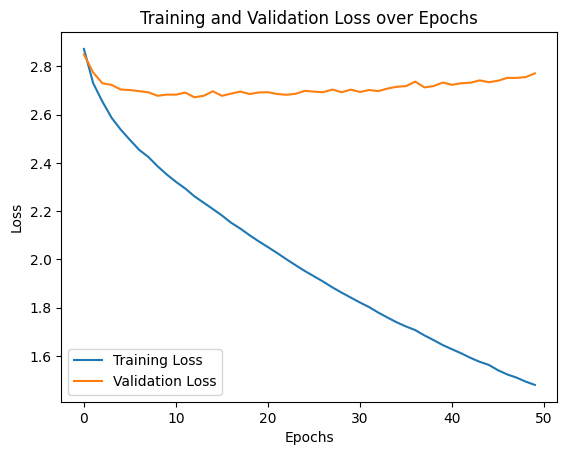

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [292]:
print(history.history['val_loss'])

[2.768392324447632, 2.717078447341919, 2.6906464099884033, 2.677044630050659, 2.672067165374756, 2.6730172634124756, 2.6804423332214355, 2.677828550338745, 2.701930284500122, 2.704619884490967, 2.704582452774048, 2.7109756469726562, 2.714672803878784, 2.717350959777832, 2.7205722332000732, 2.7246615886688232, 2.7266247272491455, 2.743152618408203, 2.7441468238830566, 2.7436859607696533, 2.7563750743865967, 2.7560036182403564, 2.759014844894409, 2.7730562686920166, 2.7749547958374023, 2.797717571258545, 2.7876362800598145, 2.791280746459961, 2.7975168228149414, 2.8067407608032227, 2.8228063583374023, 2.8159735202789307, 2.82600736618042, 2.844458818435669, 2.828561305999756, 2.8165318965911865, 2.823777914047241, 2.853775978088379, 2.8579134941101074, 2.84924054145813, 2.874861717224121, 2.8635976314544678, 2.8786818981170654, 2.8759257793426514, 2.8929593563079834, 2.8917853832244873, 2.883899450302124, 2.903913974761963, 2.9267208576202393, 2.93739652633667]


Overfitting starts after 10 epochs

L2-Regularization

In [40]:
from keras import regularizers

In [41]:
dummy_model_l2 = models.Sequential([
    layers.InputLayer(input_shape=X_train_true_scaled.shape[1]),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(14, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

dummy_model_l2.compile(optimizer='adam', loss='categorical_crossentropy')
history_l2 = dummy_model_l2.fit(X_train_true_scaled, y_train_true_encoded, epochs=100, 
                          validation_data=(X_train_valid_scaled, y_train_valid_encoded), verbose=0,
                          class_weight=class_weights_dummy)

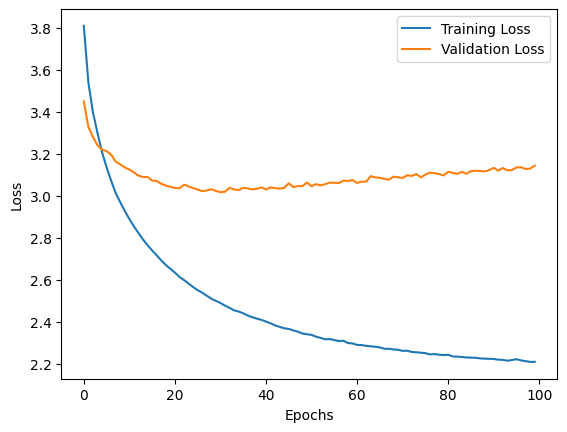

In [74]:
plt.plot(history_l2.history['loss'], label='Training Loss')
plt.plot(history_l2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.title('Training and Validation Loss over Epochs with L2-Regularization')
plt.show()

Overfitting stats after 25 epochs

L1-Regularization

In [43]:
dummy_model_l1 = models.Sequential([
    layers.InputLayer(input_shape=X_train_true_scaled.shape[1]),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(14, activation='softmax', kernel_regularizer=regularizers.l1(0.01))
])

dummy_model_l1.compile(optimizer='adam', loss='categorical_crossentropy')
history_l1 = dummy_model_l1.fit(X_train_true_scaled, y_train_true_encoded, epochs=200, 
                          validation_data=(X_train_valid_scaled, y_train_valid_encoded), verbose=0,
                          class_weight=class_weights_dummy)

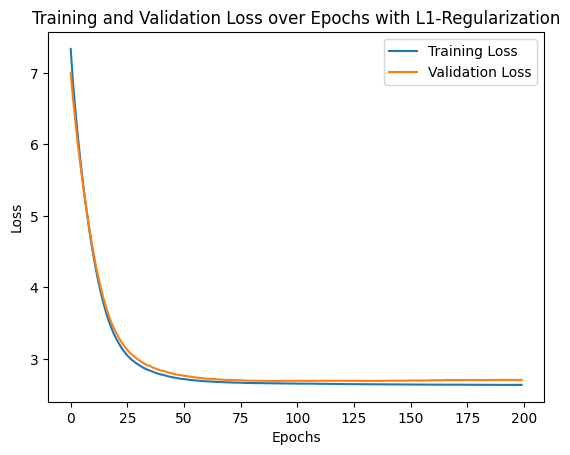

In [44]:
plt.plot(history_l1.history['loss'], label='Training Loss')
plt.plot(history_l1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs with L1-Regularization')
plt.show()

Overfitting starts after 75 epochs

Dropout

In [45]:
dummy_model_dropout = models.Sequential([
    layers.InputLayer(input_shape=X_train_true_scaled.shape[1]),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(14, activation='softmax')
])

dummy_model_dropout.compile(optimizer='adam', loss='categorical_crossentropy')
history_dropout = dummy_model_dropout.fit(X_train_true_scaled, y_train_true_encoded, epochs=200, 
                          validation_data=(X_train_valid_scaled, y_train_valid_encoded), verbose=0,
                          class_weight=class_weights_dummy)

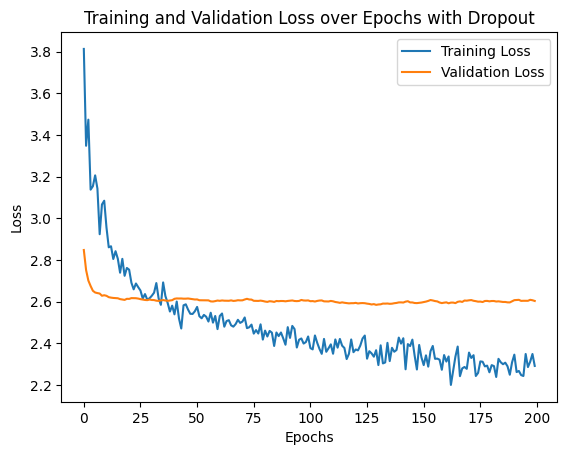

In [46]:
plt.plot(history_dropout.history['loss'], label='Training Loss')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs with Dropout')
plt.show()

Overfitting starts at 15 epochs

#### NN Basic

In [70]:
after_preprocessing_nn_basic = Pipeline(steps=[
    ('nn_model', NeuralNetworkEstimator(epochs=10))
])

In [71]:
grid_search_nn_basic = GridSearchCV(
    estimator=after_preprocessing_nn_basic,
    param_grid=param_grid_nn,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [72]:
nn_basic_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('nn', grid_search_nn_basic)
])

In [73]:
nn_basic_model.fit(X_train, y_train)

5/5 [==============================] - 0s 1ms/step


Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         NeuralNetworkEstimator(epochs=10))]),
                              param_grid={'nn_model__batch_size': [16, 32],
                                          'nn_model__beta1': [0.8, 0.9],
                                          'nn_model__beta2': [0.99, 0.999],
                                          'nn_model__learning_rate': [0.0001,
                                                                      0.001,
                                                                      0.01],
                                          'nn_model__weight_initializer': ['glorot_uniform',
                                                                           'glorot_normal',
                                                                           'ones'],
                                          'nn_model__widths': [[], [64],
                                                               [64, 32]]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [75]:
clf = nn_basic_model.named_steps['nn']
clf.best_score_

0.09652205011998716

In [76]:
clf.best_params_

{'nn_model__batch_size': 16,
 'nn_model__beta1': 0.9,
 'nn_model__beta2': 0.999,
 'nn_model__learning_rate': 0.0001,
 'nn_model__weight_initializer': 'glorot_normal',
 'nn_model__widths': [64]}

#### L2-Regularization

In [78]:
after_preprocessing_nn_l2reg = Pipeline(steps=[
    ('nn_model', NeuralNetworkEstimator(epochs=25, l2_reg=True))
])

In [79]:
grid_search_nn_l2reg = GridSearchCV(
    estimator=after_preprocessing_nn_l2reg,
    param_grid=param_grid_nn,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [80]:
nn_l2reg_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('nn', grid_search_nn_l2reg)
])

In [81]:
nn_l2reg_model.fit(X_train, y_train)

5/5 [==============================] - 0s 1ms/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 1ms/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 986us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [ 0.0126131   0.03822358 -0.03943478 -0.01633149  0.00889422 -0.02453504
 -0.00363762  0.02139393 -0.00857361  0.04009678  0.0337853   0.00177208
  0.00720357  0.03118722 -0.05083083  0.11464078 -0.00839449 -0.00285617
  0.04296856 -0.01600469  0.0323585   0.02489282  0.01568732  0.01551014
  0.06309816 -0.02953454  0.          0.00338626 -0.03479856  0.00973822
  0.00546341 -0.05274708 -0.02750525  0.00700533  0.04989014  0.01682508
  0.11479112  0.02465057 -0.01136137  0.03499017 -0.00630082  0.03736928
  0.04452913  0.01587391  0.00394063  0.07428799 -0.01057554  0.02063234
  0.03458058 -0.01267974  0.01673597  0.06241734 -0.02784703  0.00729322
 -0.00485366  0.01624222  0.07324708 -0.03330634 -0.01480025 -0.02916557
  0.01529006  0.0353909   0.00053386  0.02406592 -0.02046386  0.00810769
  0.02411948  0.0108939

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         NeuralNetworkEstimator(epochs=25,
                                                                                l2_reg=True))]),
                              param_grid={'nn_model__batch_size': [16, 32],
                                          'nn_model__beta1': [0.8, 0.9],
                                          'nn_model__beta2': [0.99, 0.999],
                                          'nn_model__learning_rate': [0.0001,
                                                                      0.001,
                                                                      0.01],
                                          'nn_model__weight_initializer': ['glorot_uniform',
                                                                           'glorot_normal',
                                                                           'ones'],
                                          'nn_model__widths': [[], [64],
                                                               [64, 32]]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [82]:
clf = nn_l2reg_model.named_steps['nn']
clf.best_score_

0.11479112498329125

In [338]:
clf.best_params_

{'nn_model__batch_size': 32,
 'nn_model__beta1': 0.8,
 'nn_model__beta2': 0.999,
 'nn_model__learning_rate': 0.01,
 'nn_model__weight_initializer': 'ones',
 'nn_model__widths': [64, 32]}

#### L1-Regularization

In [87]:
after_preprocessing_nn_l1reg = Pipeline(steps=[
    ('nn_model', NeuralNetworkEstimator(epochs=75, l1_reg=True))
])

In [88]:
grid_search_nn_l1reg = GridSearchCV(
    estimator=after_preprocessing_nn_l1reg,
    param_grid=param_grid_nn,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [89]:
nn_l1reg_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('nn', grid_search_nn_l1reg)
])

In [90]:
nn_l1reg_model.fit(X_train, y_train)

5/5 [==============================] - 0s 748us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 749us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 997us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 998us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 997us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 809us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:695: RuntimeWarning: invalid value encountered in divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


5/5 [==============================] - 0s 997us/step


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [ 0.00077192 -0.00654442  0.04722676  0.02101786  0.00202468  0.04259812
  0.00091507  0.00306003 -0.01630982 -0.00602346  0.04800433  0.0144552
  0.03368845 -0.00698277 -0.0028057   0.04348227  0.01040314  0.
  0.07170396  0.01729248  0.0081314   0.05174092  0.04465786 -0.01359541
  0.06494251  0.08108773  0.          0.0144517  -0.00350722 -0.03609326
  0.02148237 -0.01084758  0.01574756  0.02336575  0.01181962 -0.06611868
  0.03100208  0.00273573 -0.01823112  0.0198952   0.00947459  0.01109643
  0.05712314  0.02018434  0.01279762  0.04294416  0.01620961         nan
  0.04496396  0.00985093 -0.01646688  0.04155133 -0.02455194  0.
  0.00973431 -0.07690004  0.00282712 -0.03655503 -0.03387616 -0.0282934
  0.01434408  0.01406574  0.00472333 -0.01076128  0.00306979 -0.0250974
 -0.0160018  -0.02445038 -0.02245781  0.02

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         NeuralNetworkEstimator(epochs=75,
                                                                                l1_reg=True))]),
                              param_grid={'nn_model__batch_size': [16, 32],
                                          'nn_model__beta1': [0.8, 0.9],
                                          'nn_model__beta2': [0.99, 0.999],
                                          'nn_model__learning_rate': [0.0001,
                                                                      0.001,
                                                                      0.01],
                                          'nn_model__weight_initializer': ['glorot_uniform',
                                                                           'glorot_normal',
                                                                           'ones'],
                                          'nn_model__widths': [[], [64],
                                                               [64, 32]]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [91]:
clf = nn_l1reg_model.named_steps['nn']
clf.best_score_

0.08743594912348832

In [92]:
clf.best_params_

{'nn_model__batch_size': 32,
 'nn_model__beta1': 0.9,
 'nn_model__beta2': 0.99,
 'nn_model__learning_rate': 0.01,
 'nn_model__weight_initializer': 'glorot_uniform',
 'nn_model__widths': [64]}

#### Dropout

In [93]:
after_preprocessing_nn_dropout = Pipeline(steps=[
    ('nn_model', NeuralNetworkEstimator(epochs=15, dropout=True))
])

In [94]:
grid_search_nn_dropout = GridSearchCV(
    estimator=after_preprocessing_nn_dropout,
    param_grid=param_grid_nn,
    scoring=custom_cohen_kappa_scorer,
    cv = cv_splitter
)

In [95]:
nn_dropout_model = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_scaling),
    ('nn', grid_search_nn_dropout)
])

In [96]:
nn_dropout_model.fit(X_train, y_train)

5/5 [==============================] - 0s 997us/step


Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('remove_specific_features',
                                  RemoveFeatures(features_to_remove=['DS',
                                                                     'PDS',
                                                                     'FOA',
                                                                     'FOW',
                                                                     'FO%',
                                                                     'PFOA',
                                                                     'PFOW',
                                                                     'PFO%',
                                                                     'SOG',
                                                                     'PSOG',
                                                                     'PSOWG',
                                                                     'PSOGP',
                                                                     'PSO/G',
                                                                     'PSO%',
                                                                     'PATT'])),
                                 ('missing_value_imputation',
                                  MissingValueImputation(pim_model=GridSearchCV(estimator=Pipeline(steps=[('data_preprocessing',
                                                                                                           ColumnT...
                                                         NeuralNetworkEstimator(dropout=True,
                                                                                epochs=15))]),
                              param_grid={'nn_model__batch_size': [16, 32],
                                          'nn_model__beta1': [0.8, 0.9],
                                          'nn_model__beta2': [0.99, 0.999],
                                          'nn_model__learning_rate': [0.0001,
                                                                      0.001,
                                                                      0.01],
                                          'nn_model__weight_initializer': ['glorot_uniform',
                                                                           'glorot_normal',
                                                                           'ones'],
                                          'nn_model__widths': [[], [64],
                                                               [64, 32]]},
                              scoring=make_scorer(custom_cohen_kappa, response_method='predict')))])

In [97]:
clf = nn_dropout_model.named_steps['nn']
clf.best_score_

0.10427698094391365

In [98]:
clf.best_params_

{'nn_model__batch_size': 32,
 'nn_model__beta1': 0.9,
 'nn_model__beta2': 0.999,
 'nn_model__learning_rate': 0.001,
 'nn_model__weight_initializer': 'glorot_uniform',
 'nn_model__widths': [64]}

## Best Model Analysis

In [138]:
import joblib

In [139]:
decisiontree_model = joblib.load('../models/best_model/decision_tree_best_model.pkl')

In [142]:
predictions_test = decisiontree_model.predict(X_test)

In [144]:
custom_cohen_kappa(y_test, predictions_test)

0.12879112549379745